<a href="https://colab.research.google.com/github/ziatdinovmax/Notebooks-for-papers/blob/master/rVAE_PFM_v2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disentangling ferroelectric domain wall geometries via variational autoencoder

*Maxim Ziatdinov & Sergei Kalinin*

*Oak Ridge National Laboratory*

This notebook demonstrates application of rotationally-invariant variational autoencoder for (unsupervised) analysis of ferroelectric domain wall geometries and pathways in dynamic piezoresponse force microscopy (PFM). For the detailed discussion of the results, please see our paper.

Install AtomAI:

In [ ]:
!pip install -q atomai==0.3.5

Download experimental PFM data:

In [2]:
!gdown https://drive.google.com/uc?id=1fn9-GhIXnVoXNSL4kxSI_S1Q4GqWORTO
!gdown https://drive.google.com/uc?id=134fUHC6ekOpq4gLdVjzUnHbi1mM6kV9i

Downloading...
From: https://drive.google.com/uc?id=1fn9-GhIXnVoXNSL4kxSI_S1Q4GqWORTO
To: /content/s-Nuc-RsinThmask-56.2761to56.2761-8bit (1).tif
100% 2.05M/2.05M [00:00<00:00, 65.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=134fUHC6ekOpq4gLdVjzUnHbi1mM6kV9i
To: /content/s-Growth-RsinThmask-56.0449to56.0449-8bit (1).tif
3.36MB [00:00, 52.6MB/s]


Imports:

In [3]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from atomai.experimental import vae
from atomai import utils

Next we read the PFM data. There are two datasets: one describing domain growth and another with domain nucleation. Each dataset is a stack of sequentially acquired 2D PFM images.

(60, 226, 247)


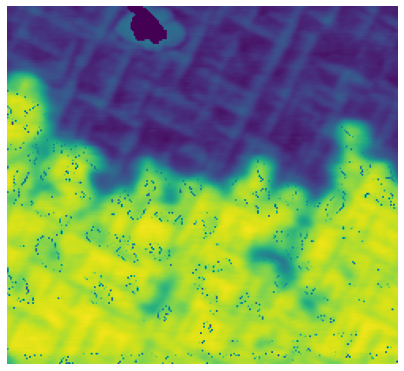

In [4]:
filename = '/content/s-Growth-RsinThmask-56.0449to56.0449-8bit (1).tif'
#filename = "/content/s-Nuc-RsinThmask-56.2761to56.2761-8bit (1).tif"

imgdata = cv2.imreadmulti(filename)
imgdata = np.array(imgdata[1])

print(imgdata.shape)
plt.figure(figsize=(7, 7))
plt.imshow(imgdata[30])
plt.axis('off')
plt.show()

Normalize:

In [5]:
imgdata = imgdata / imgdata.max()

The rotationally-invariant variational autoencoder (rVAE) is trained on a stacks of smaller images (subimages) extracted from the PFM movie.

In [6]:
window_sizes = [8, 16, 32, 64] # defines size of each subimage
steps = [16, 16, 16, 32] # determines coordinate grid spacing

for ws, s in zip(window_sizes, steps):
    # create a uniform coordinate grid
    coordinates = utils.get_coord_grid(imgdata, s)
    # extract subimage for each point on a grid
    imstack, com, frames = utils.extract_subimages(imgdata, coordinates, ws)
    # train VAE using the constructed stack of subimages
    rvae = vae.rVAE(
        imstack, minibatch_size=50, training_cycles=500,
        numhidden_encoder=512, numhidden_decoder=512)
    rvae.run()
    # store the trained model on Google Drive (you will need to adjust a path)
    rvae.save_weights("/content/drive/My Drive/research/rVAE_PFM/rVAE_Growth_ws{}".format(ws))
    print('\n')

Epoch: 1/500, Training loss: 5.4676, Test loss: 2.5555
Epoch: 2/500, Training loss: 1.9124, Test loss: 1.4293
Epoch: 3/500, Training loss: 1.3258, Test loss: 1.3506
Epoch: 4/500, Training loss: 1.2633, Test loss: 1.2773
Epoch: 5/500, Training loss: 1.2623, Test loss: 1.2927
Epoch: 6/500, Training loss: 1.2599, Test loss: 1.2709
Epoch: 7/500, Training loss: 1.2651, Test loss: 1.2339
Epoch: 8/500, Training loss: 1.2538, Test loss: 1.3060
Epoch: 9/500, Training loss: 1.2325, Test loss: 1.2146
Epoch: 10/500, Training loss: 1.2627, Test loss: 1.2993
Epoch: 11/500, Training loss: 1.2250, Test loss: 1.2244
Epoch: 12/500, Training loss: 1.2289, Test loss: 1.2220
Epoch: 13/500, Training loss: 1.2401, Test loss: 1.2380
Epoch: 14/500, Training loss: 1.2440, Test loss: 1.2423
Epoch: 15/500, Training loss: 1.2277, Test loss: 1.3611
Epoch: 16/500, Training loss: 1.2478, Test loss: 1.2793
Epoch: 17/500, Training loss: 1.2609, Test loss: 1.2421
Epoch: 18/500, Training loss: 1.2544, Test loss: 1.2401
E

Load back all the trained models:

In [8]:
rvae_ws8 = vae.EncoderDecoder((8, 8), 2, numhidden_encoder=512, numhidden_decoder=512)
rvae_ws8.load_weights("/content/drive/My Drive/research/rVAE_PFM/rVAE_Growth_ws8.tar")
rvae_ws16 = vae.EncoderDecoder((16, 16), 2, numhidden_encoder=512, numhidden_decoder=512)
rvae_ws16.load_weights("/content/drive/My Drive/research/rVAE_PFM/rVAE_Growth_ws16.tar")
rvae_ws32 = vae.EncoderDecoder((32, 32), 2, numhidden_encoder=512, numhidden_decoder=512)
rvae_ws32.load_weights("/content/drive/My Drive/research/rVAE_PFM/rVAE_Growth_ws32.tar")
rvae_ws64 = vae.EncoderDecoder((64, 64), 2, numhidden_encoder=512, numhidden_decoder=512)
rvae_ws64.load_weights("/content/drive/My Drive/research/rVAE_PFM/rVAE_Growth_ws64.tar")

rvae_models = [rvae_ws8, rvae_ws16, rvae_ws32, rvae_ws64]

Plot the learned 2d manifold for each model:

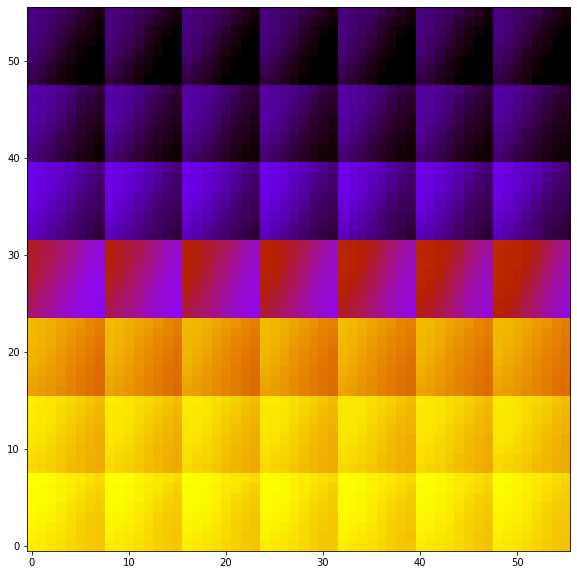

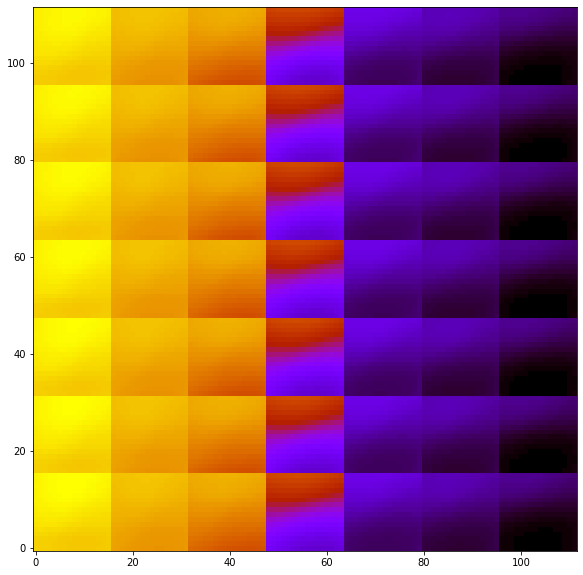

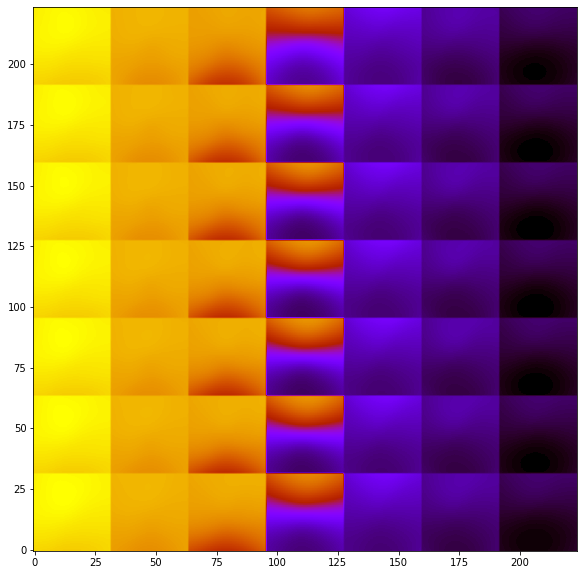

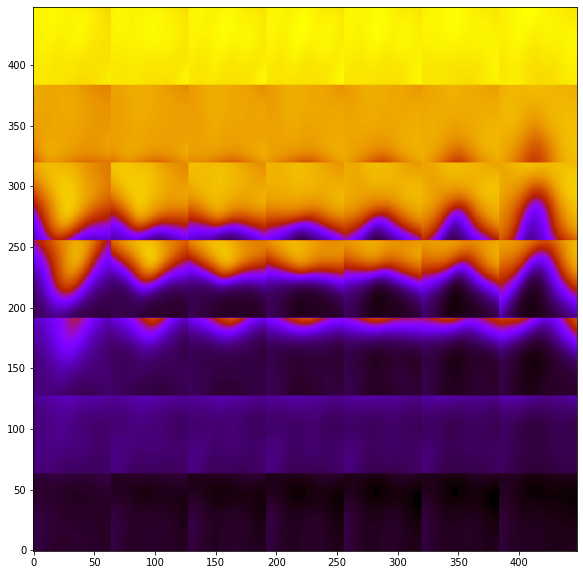

In [9]:
for rvae_ in rvae_models:
    rvae_.manifold2d(d=7)

We next encode angle, offsets and image latent variables for each model:

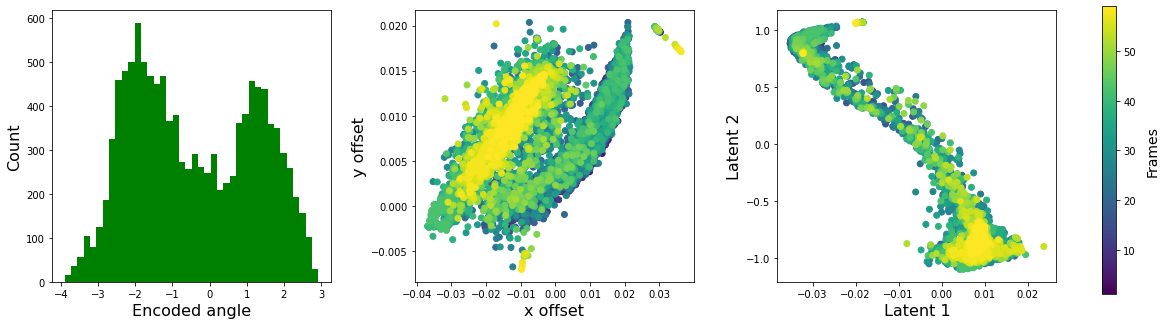

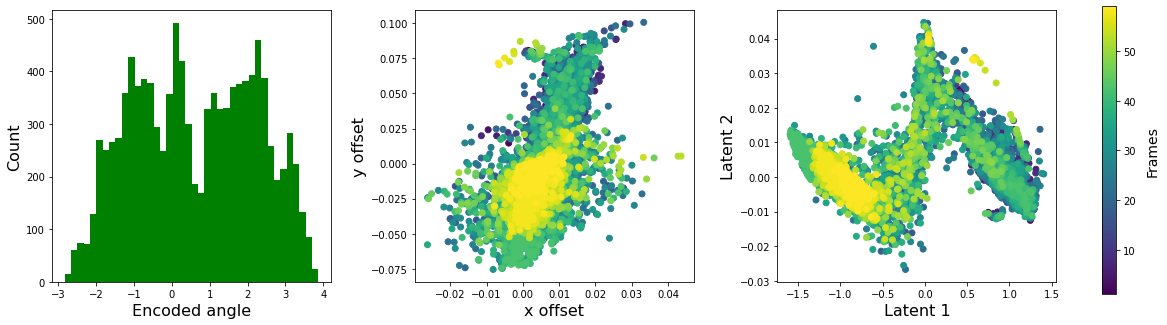

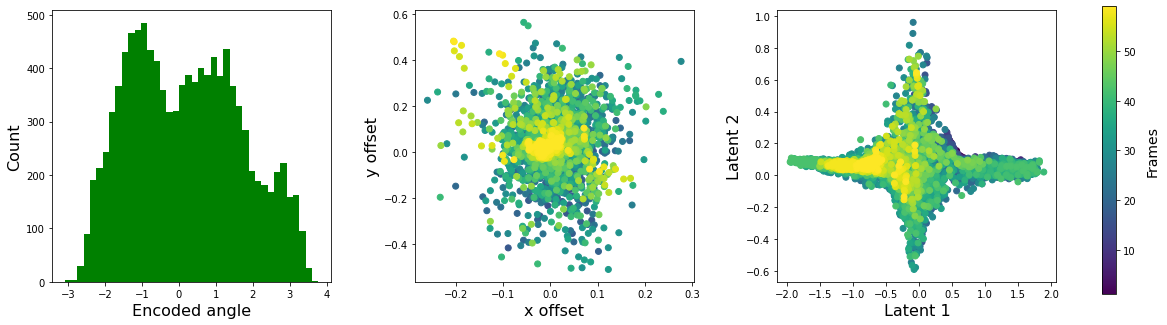

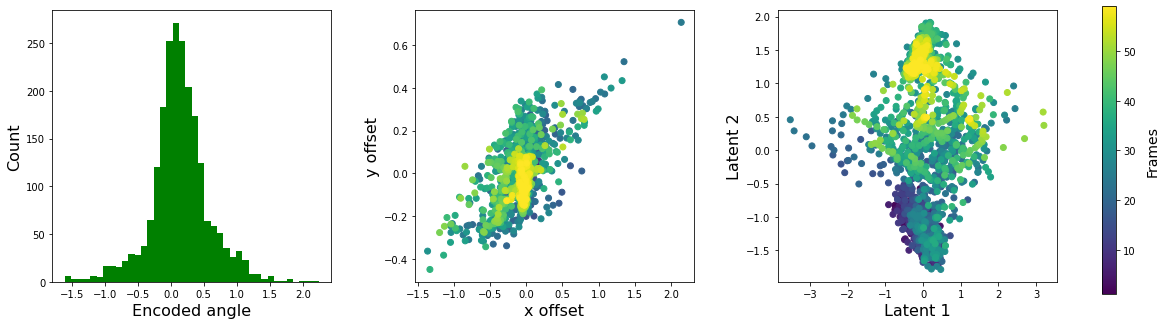

In [10]:
window_sizes = [8, 16, 32, 64]
steps = [16, 16, 16, 32]

for rvae_, ws, s in zip(rvae_models, window_sizes, steps):
    # Generate stack of images given window size and step
    coordinates = utils.get_coord_grid(imgdata, s)
    imstack, com, frames = utils.extract_subimages(imgdata, coordinates, ws)
    # Encode the generated image stack
    z_mean, _ = rvae_.encode(imstack)
    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.hist(z_mean[:, 0], bins=40, color="green")
    ax1.set_xlabel("Encoded angle", fontsize=16)
    ax1.set_ylabel("Count", fontsize=16)
    ax2.scatter(z_mean[:, 1], z_mean[:, 2], c=frames)
    ax2.set_xlabel("x offset", fontsize=16)
    ax2.set_ylabel("y offset", fontsize=16)
    ax3.scatter(z_mean[:, 3], z_mean[:, 4], c=frames)
    ax3.set_xlabel("Latent 1", fontsize=16)
    ax3.set_ylabel("Latent 2", fontsize=16)
    clrbar = np.linspace(1, np.max(frames)).reshape(-1, 1)
    ax_ = fig.add_axes([.68, .09, .30, .80])
    img = plt.imshow(clrbar)
    plt.gca().set_visible(False)
    clrbar = plt.colorbar(img, ax=ax_, orientation='vertical')
    clrbar.set_label('Frames', fontsize=14, labelpad=10)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

We can also extract a "line profile" of decoded (generated) images in any dierection that we want:

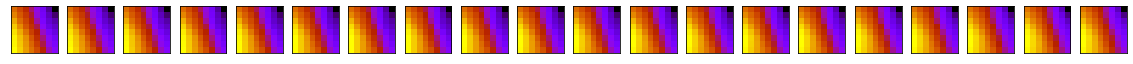

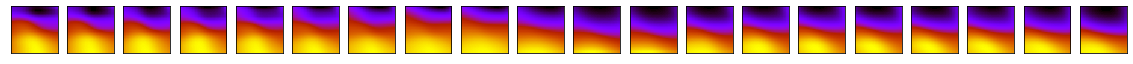

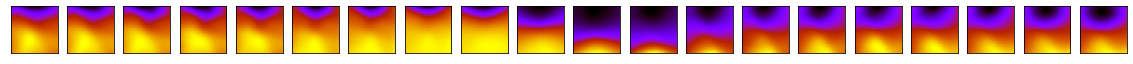

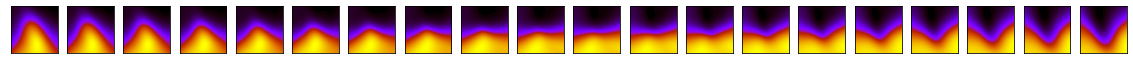

In [11]:
# Create a coordinate array
lv1_vals = np.linspace(-1.5, 1.5, 20)
lv2_vals = np.zeros_like(lv1_vals)
lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)

# Decode with different pre-trained models
for rvae_ in rvae_models:
    decoded = rvae_.decode(lv_vals)
    # Plot results
    n = len(lv1_vals)
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(decoded[i], cmap="gnuplot")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Now let's encode every pixel in the original dataset (may take ~1-2 min per each rVAE model):

In [12]:
encoded_imgs = {}
for i, rvae_ in enumerate(rvae_models):
    dictionary = OrderedDict()
    img, img_encoded = rvae_.encode_images(imgdata)
    dictionary["image"] = img
    dictionary["encoded"] = img_encoded
    encoded_imgs[i] = dictionary
    print('\n')

Image 60/60

Image 60/60

Image 60/60

Image 60/60



Plot results for selected frame:

(notice that the row-column arrangement of latent variables may be different from the paper)

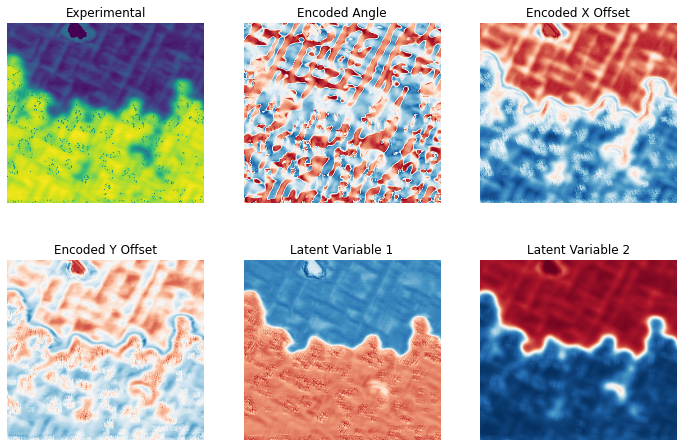

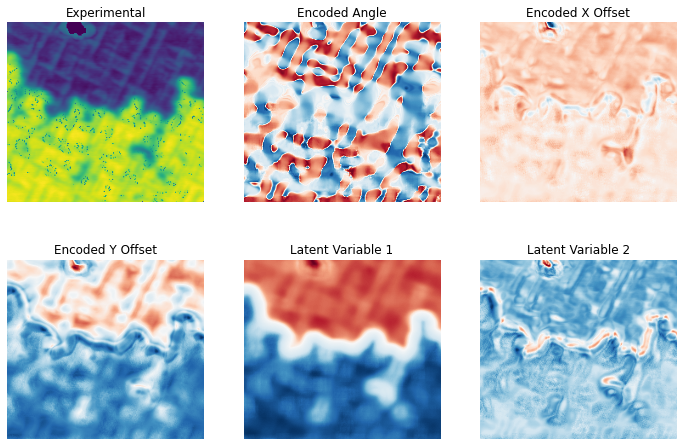

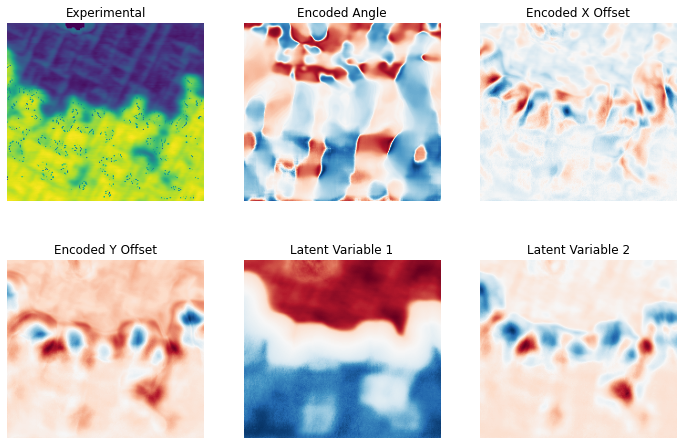

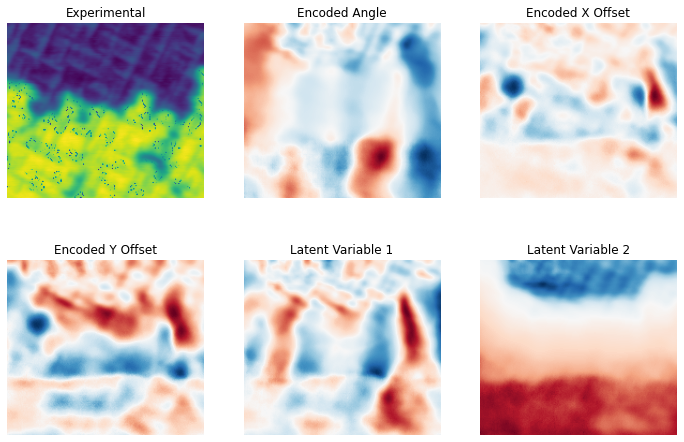

In [13]:
k = 30 # select frame


for val in encoded_imgs.values():
    img, img_encoded = val.values()

    nc = img_encoded.shape[-1] + 1
    rows = int(np.ceil(float(nc)/5))
    cols = int(np.ceil(float(nc)/rows))
    titles = ["Encoded Angle", "Encoded X Offset", "Encoded Y Offset"]
    titles_ = ["Latent Variable {}".format(i + 1) for i in range(nc - 3)]
    titles = titles + titles_
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
    for i in range(nc):
        ax = fig.add_subplot(gs[i])
        if i == 0:
            ax.imshow(img[k])
            ax.set_title("Experimental")
            ax.axis('off')
        else:
            ax.imshow(img_encoded[k,..., i - 1], cmap='RdBu_r')
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_title(titles[i - 1 ])
    plt.show()
    print('\n')